In [1]:
import os
import numpy as np
import argparse
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# import visdom
# import collections.abc
import collections
from utility import PGMdataset, RAVENdataset, ToTensor
from sran import SRAN



/common/home/pv217/.conda/envs/gln_new/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class args():
    model='SRAN'
    epochs=100
    batch_size=64
    seed=12345
    dataset = 'I-RAVEN'
    device = 3
    load_workers = 16
    resume = ''
    dataset_path = "/common/users/pv217/four_config_data_pth/pritish_data"
    save = "/common/users/pv217/model_checkpoints/full_cnn_lstm"
    img_size = 64
    lr = 1e-4
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    meta_alpha = 0.0
    meta_beta = 0.0
    cuda = torch.cuda.is_available()    
    visdom = False
    debug = False
    

In [3]:
# parser = argparse.ArgumentParser(description='our_model')
# parser.add_argument('--model', type=str, default='SRAN')
# parser.add_argument('--dataset', type=str, default='I-RAVEN', choices=['PGM', 'I-RAVEN'])
# parser.add_argument('--img_size', type=int, default=224)
# parser.add_argument('--epochs', type=int, default=200)
# parser.add_argument('--batch_size', type=int, default=32)
# parser.add_argument('--seed', type=int, default=12345)
# parser.add_argument('--load_workers', type=int, default=16)
# parser.add_argument('--resume', type=str, default='')
# #parser.add_argument('--dataset_path', type=str, default='/media/dsg3/datasets/PGM')
# parser.add_argument('--dataset_path', type=str, default='/media/dsg3/datasets/I-RAVEN')
# parser.add_argument('--save', type=str, default='/media/dsg3/hs')
# parser.add_argument('--lr', type=float, default=1e-4)
# parser.add_argument('--beta1', type=float, default=0.9)
# parser.add_argument('--beta2', type=float, default=0.999)
# parser.add_argument('--epsilon', type=float, default=1e-8)
# parser.add_argument('--meta_beta', type=float, default=0.0)
# parser.add_argument('--visdom', default=True, help='Use visdom for visualization')
# parser.add_argument('--cuda', default=True )
# parser.add_argument('--debug', default=False)



In [4]:
# args = parser.parse_args()
torch.cuda.set_device(args.device)
torch.cuda.manual_seed(args.seed)
args.save += '/' + args.dataset+'/'
start_time = time.strftime ('%Y-%m-%d_%H-%M-%S') 
if args.debug:
    args.save += args.dataset + '/'
    args.visdom = False
else:
    args.save += args.dataset +'_' + start_time + '/'
if not os.path.exists(args.save):
    os.makedirs(args.save)

In [5]:
args.train_figure_configurations = [0,1,2,3,4,5,6]
args.val_figure_configurations = args.train_figure_configurations
args.test_figure_configurations = [0,1,2,3,4,5,6]
train = RAVENdataset(args.dataset_path, "train", args.train_figure_configurations, args.img_size, transform=transforms.Compose([ToTensor()]), shuffle = True)
valid = RAVENdataset(args.dataset_path, "val", args.val_figure_configurations, args.img_size, transform=transforms.Compose([ToTensor()]))
test = RAVENdataset(args.dataset_path, "test", args.test_figure_configurations, args.img_size, transform=transforms.Compose([ToTensor()]))

In [6]:
trainloader = DataLoader(train, batch_size=args.batch_size, shuffle=True, num_workers=args.load_workers)
validloader = DataLoader(valid, batch_size=args.batch_size, shuffle=False, num_workers=args.load_workers)
testloader = DataLoader(test, batch_size=args.batch_size, shuffle=False, num_workers=args.load_workers)

In [7]:
print ('Dataset:', args.dataset)
print ('Train/Validation/Test:{0}/{1}/{2}'.format(len(train), len(valid), len(test)))
print ('Image size:', args.img_size)

Dataset: I-RAVEN
Train/Validation/Test:24000/8000/8000
Image size: 64


In [8]:
if args.model == 'SRAN':
    model = SRAN(args)
start_epoch = 0
# if args.resume:
#     args.resume_epoch = 78
#     model.load_model(args.resume, args.resume_epoch)
#     print('Loaded model')
#     start_epoch = args.resume_epoch+1
# with open(os.path.join(args.save, 'results.log'), 'w') as f:
#     for key, value in vars(args).items():
#         f.write('{0}: {1}\n'.format(key, value))
#     f.write('--------------------------------------------------\n')

# pmodel = torch.nn.DataParallel(model)
# torch.backends.cudnn.benchmark = True
pmodel = model.cuda()

In [9]:
if args.visdom:
    viz = visdom.Visdom(port = 9527, env = args.dataset)

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0
    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(trainloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
#             print(1)
            target = target.cuda()
#             print(2)
            meta_target = meta_target.cuda()
#             print(3)
        model.optimizer.zero_grad()
        output = pmodel(image)
#         print(4)
        loss = model.compute_loss(output, target, meta_target)
        loss.backward()
        model.optimizer.step()
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100. / target.size()[0]
        loss, acc = loss.item(), accuracy
#         print('Train: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc))
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Avg Training Loss: {:.6f}".format(loss_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

In [11]:
def validate(epoch):
    model.eval()
    accuracy = 0
    acc_all = 0.0
    loss_all = 0.0
    counter = 0
    with torch.no_grad():
        for batch_idx, (image, target, meta_target) in enumerate(validloader):
            counter += 1
            if args.cuda:
                image = image.cuda()
                target = target.cuda()
                meta_target = meta_target.cuda()    
            output = pmodel(image)  
            loss = model.compute_loss(output, target, meta_target)
            pred = output[0].data.max(1)[1]
            correct = pred.eq(target.data).cpu().sum().numpy()
            accuracy = correct * 100. / target.size()[0]          
            acc = accuracy          
            acc_all += acc
            loss_all += loss.item()
    if counter > 0:
        print("Total Validation Acc: {:.4f}".format(acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

In [12]:
def test(epoch):
    model.eval()
    accuracy = 0
    acc_all = 0.0
    counter = 0
    with torch.no_grad():
        for batch_idx, (image, target, meta_target) in enumerate(testloader):
            counter += 1
            if args.cuda:
                image = image.cuda()
                target = target.cuda()
                meta_target = meta_target.cuda()   
            output = pmodel(image)
            pred = output[0].data.max(1)[1]
            correct = pred.eq(target.data).cpu().sum().numpy()
            accuracy = correct * 100. / target.size()[0]   
            acc = accuracy
            acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)



In [13]:
epoch_lst = []
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
test_acc_lst = []


for epoch in range(start_epoch, args.epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    test_acc = test(epoch)
#     model.save_model(args.save, epoch)
    epoch_lst.append(epoch)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)

Avg Training Loss: 1.975418
Total Validation Acc: 27.2000
Total Testing Acc: 26.8750
Avg Training Loss: 1.684243
Total Validation Acc: 32.7750
Total Testing Acc: 34.6625
Avg Training Loss: 1.471764
Total Validation Acc: 35.7000
Total Testing Acc: 37.5750
Avg Training Loss: 1.239293
Total Validation Acc: 37.5500
Total Testing Acc: 38.3875
Avg Training Loss: 1.006419
Total Validation Acc: 37.4125
Total Testing Acc: 37.8500
Avg Training Loss: 0.811131
Total Validation Acc: 37.7625
Total Testing Acc: 38.7250
Avg Training Loss: 0.639063
Total Validation Acc: 38.1250
Total Testing Acc: 38.7375
Avg Training Loss: 0.528507
Total Validation Acc: 37.2500
Total Testing Acc: 38.3625
Avg Training Loss: 0.445917
Total Validation Acc: 37.3500
Total Testing Acc: 39.0625
Avg Training Loss: 0.392953
Total Validation Acc: 38.3500
Total Testing Acc: 39.7875
Avg Training Loss: 0.341992
Total Validation Acc: 38.1500
Total Testing Acc: 40.0500
Avg Training Loss: 0.302264
Total Validation Acc: 38.3000
Total T

In [14]:
import pandas as pd
import seaborn as sns

In [15]:
training_stats = pd.DataFrame({'epoch':epoch_lst,
 'training_loss':train_loss_lst,
 'training_accuracy':train_acc_lst,
 'validation_loss':val_loss_lst,
 'validation_accuracy':val_acc_lst,
 'test_accuracy':test_acc_lst
})

In [16]:
training_stats = training_stats.set_index('epoch')

In [17]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='epoch'>

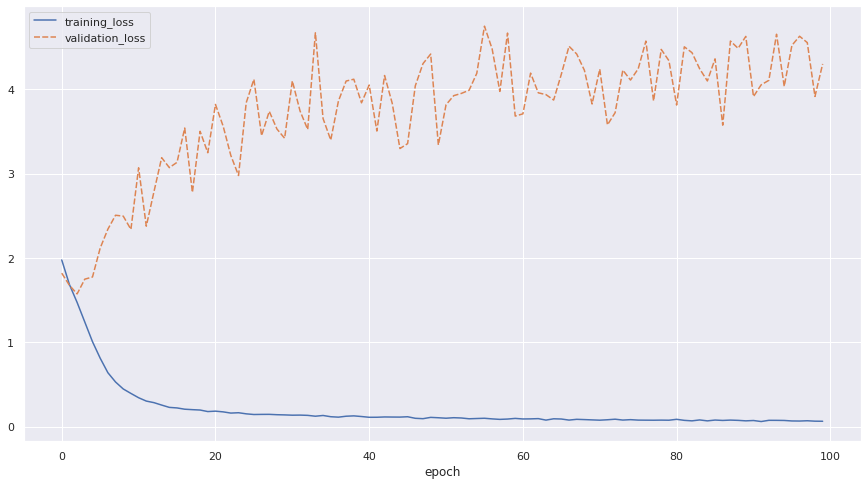

In [18]:
sns.lineplot(data=training_stats[['training_loss','validation_loss']])

<AxesSubplot:xlabel='epoch'>

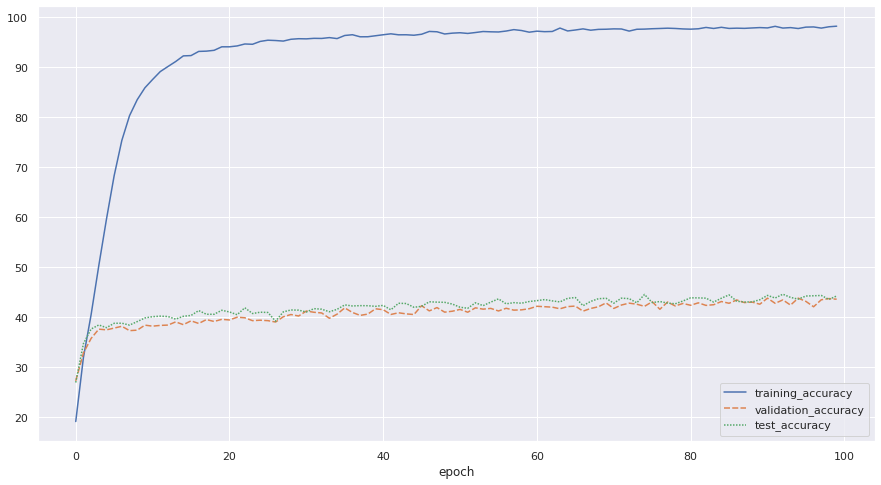

In [19]:
sns.lineplot(data=training_stats[['training_accuracy','validation_accuracy','test_accuracy']])

In [20]:
training_stats.tail(1)

,training_loss,training_accuracy,validation_loss,validation_accuracy,test_accuracy
epoch,,,,,
99,0.063016,98.1375,4.300021,43.5375,44.1875


In [21]:
training_stats.sort_values('validation_accuracy', ascending=False).head()

,training_loss,training_accuracy,validation_loss,validation_accuracy,test_accuracy
epoch,,,,,
94,0.072455,97.670833,4.034048,43.7500,43.5500
90,0.071811,97.791667,3.912872,43.7500,44.3000
98,0.063951,98.020833,3.914406,43.6625,43.5000
99,0.063016,98.137500,4.300021,43.5375,44.1875
97,0.068943,97.754167,4.552795,43.4250,44.2875


In [ ]:
def main():

    
def create_vis_plot(_xlabel, _ylabel, _title, _legend):
    return viz.line(
        X=torch.zeros((1,)),
        Y=torch.zeros((1, 3)),
        opts=dict(
            xlabel=_xlabel,
            ylabel=_ylabel,
            title=_title,
            legend=_legend
        )
    )
if __name__ == '__main__':
    main()
